# Setup

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
import keras

import warnings
warnings.filterwarnings("ignore")

In [90]:
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
plt.rcParams['figure.figsize'] = 8, 6

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

# Load the dataset

In [91]:
df = pd.read_csv('creditcard.csv')

# Exploration

In [92]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [93]:
df.isna().values.any()

False

Text(0, 0.5, 'Frequency')

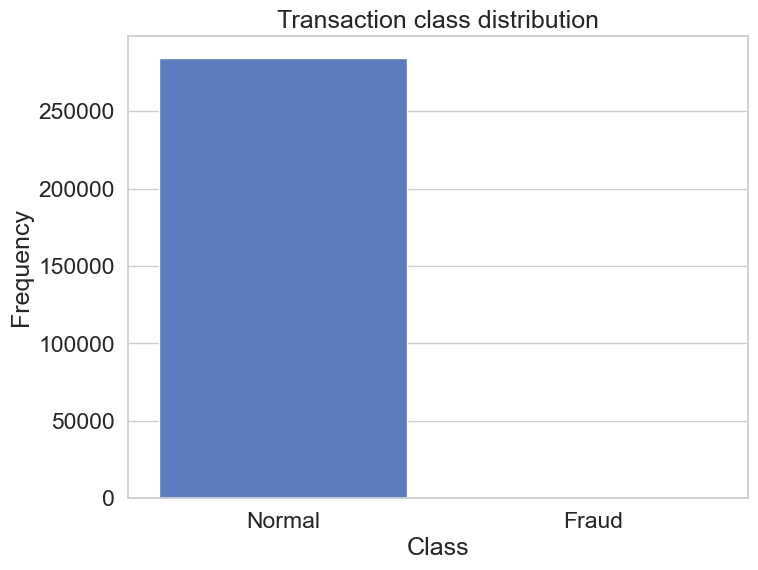

In [94]:
sns.countplot(x='Class', data=df)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [95]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [96]:
frauds.shape

(492, 31)

In [97]:
normal.shape

(284315, 31)

In [98]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [99]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

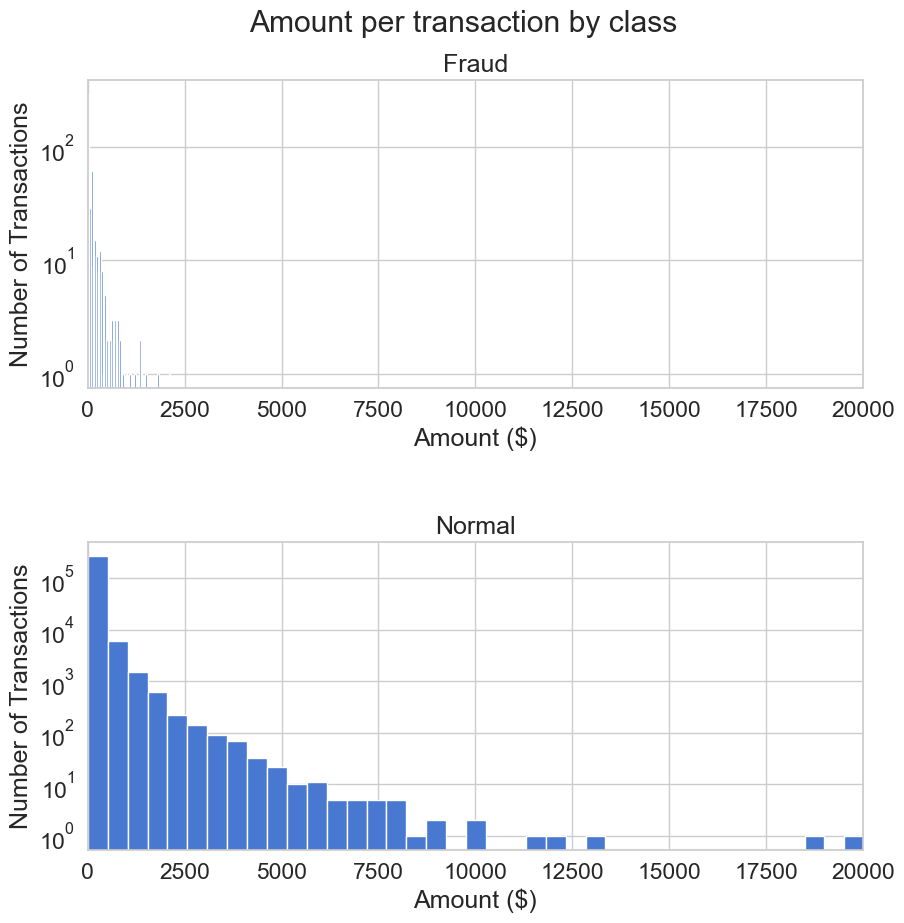

In [100]:
plt.figure(figsize=(10, 10))

plt.subplot(211)
plt.hist(frauds.Amount, bins=50)
plt.title('Fraud')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')

plt.subplot(212)
plt.hist(normal.Amount, bins=50)
plt.title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')

plt.subplots_adjust(hspace=0.5)
plt.suptitle('Amount per transaction by class', y=0.95)
plt.show()

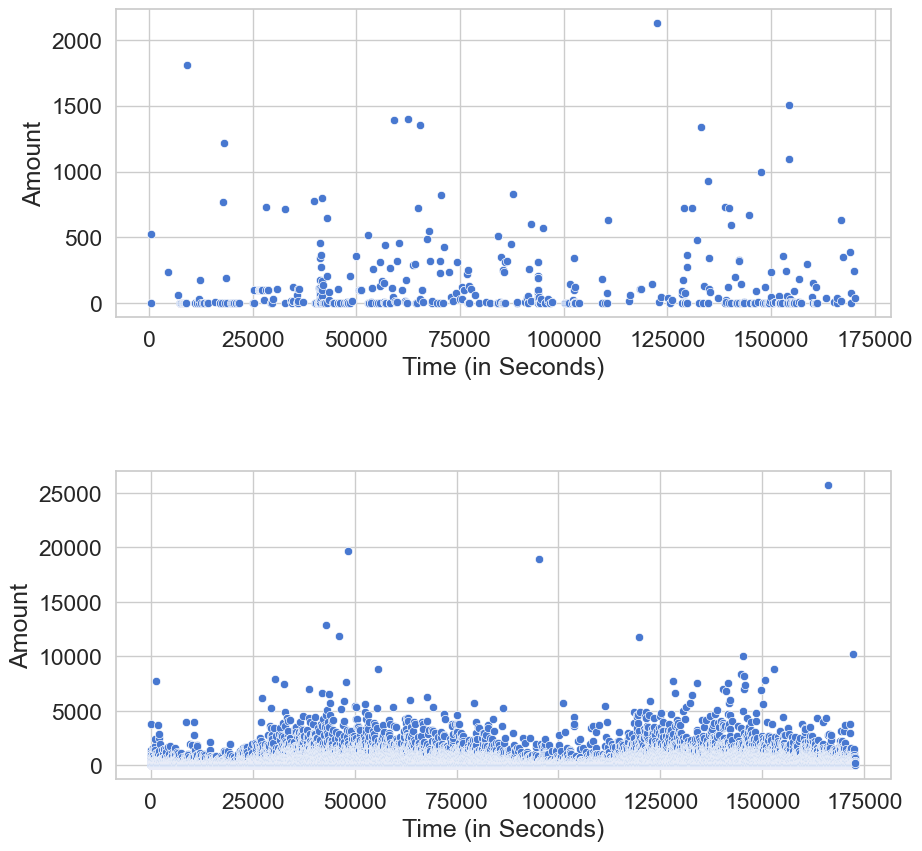

In [101]:
plt.figure(figsize=(10, 10))

plt.subplot(211)
sns.scatterplot(data=frauds, x='Time', y='Amount')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')


plt.subplot(212)
sns.scatterplot(data=normal, x='Time', y='Amount')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')

plt.subplots_adjust(hspace=0.5)
plt.show()

# Data preparation

In [102]:
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [103]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)

X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

X_train.shape

(227451, 29)

# Building the model

In [104]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [105]:
autoencoder = keras.Sequential([
    keras.layers.Dense(encoding_dim, activation="tanh", 
                       activity_regularizer=keras.regularizers.l1(10e-5), input_shape=(input_dim,)),
    keras.layers.Dense(int(encoding_dim / 2), activation="relu"),
    keras.layers.Dense(int(encoding_dim / 2), activation='tanh'),
    keras.layers.Dense(input_dim, activation='relu')
])

In [106]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint(filepath="model.h5", verbose=0, save_best_only=True)
tensorboard = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

history = autoencoder.fit(X_train, X_train, epochs=nb_epoch, batch_size=batch_size, shuffle=True,
                          validation_data=(X_test, X_test), verbose=1, callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
7108/7108 [==============================] - 15s 2ms/step - loss: 0.8211 - accuracy: 0.5765 - val_loss: 0.7912 - val_accuracy: 0.6280
Epoch 2/100
7108/7108 [==============================] - 14s 2ms/step - loss: 0.7466 - accuracy: 0.6468 - val_loss: 0.7657 - val_accuracy: 0.6648
Epoch 3/100
7108/7108 [==============================] - 16s 2ms/step - loss: 0.7286 - accuracy: 0.6739 - val_loss: 0.7567 - val_accuracy: 0.6842
Epoch 4/100
7108/7108 [==============================] - 16s 2ms/step - loss: 0.7227 - accuracy: 0.6868 - val_loss: 0.7528 - val_accuracy: 0.6940
Epoch 5/100
7108/7108 [==============================] - 16s 2ms/step - loss: 0.7190 - accuracy: 0.6945 - val_loss: 0.7498 - val_accuracy: 0.7042
Epoch 6/100
7108/7108 [==============================] - 14s 2ms/step - loss: 0.7161 - accuracy: 0.6997 - val_loss: 0.7486 - val_accuracy: 0.7050
Epoch 7/100
7108/7108 [==============================] - 16s 2ms/step - loss: 0.7138 - accuracy: 0.7016 - val_loss: 0.7457 -

In [107]:
autoencoder_model = keras.models.load_model('model.h5')

# Model evaluation

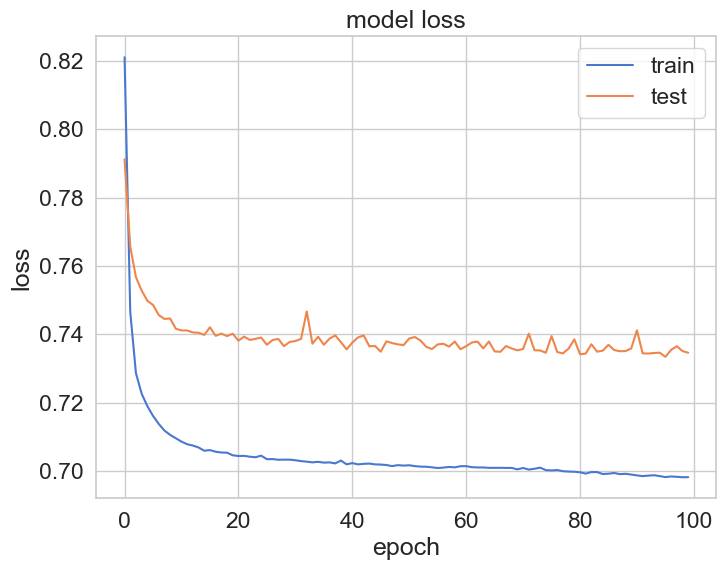

In [108]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [109]:
predictions = autoencoder.predict(X_test)

1781/1781 [==============================] - 2s 1ms/step


In [110]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [111]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.733749,0.001720
std,3.404570,0.041443
min,0.048967,0.000000
25%,0.235877,0.000000
50%,0.386868,0.000000
75%,0.607536,0.000000
max,260.280331,1.000000


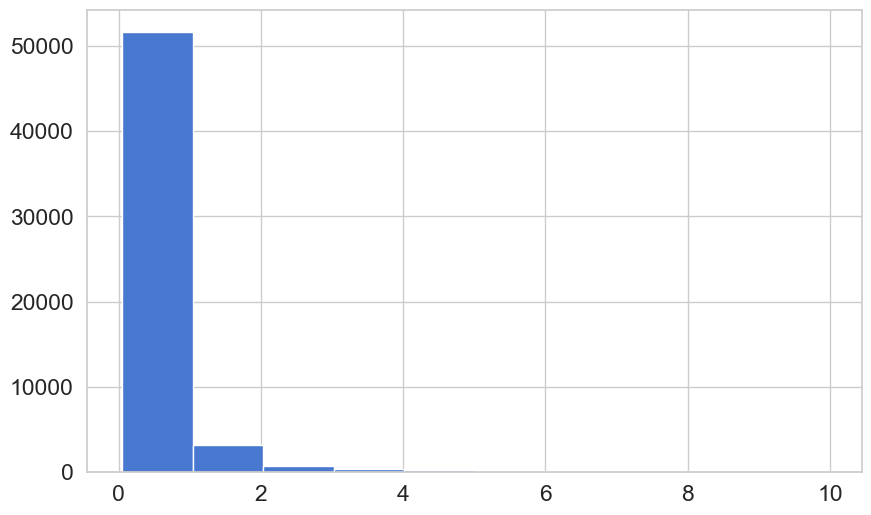

In [112]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

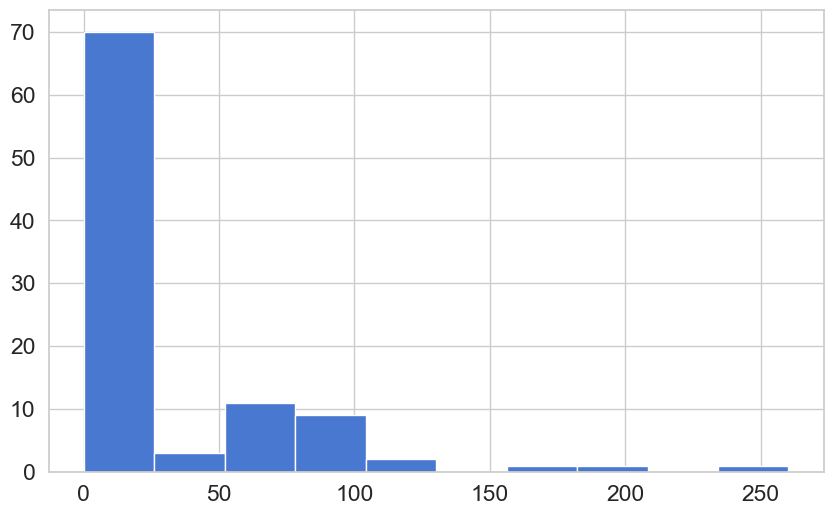

In [113]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

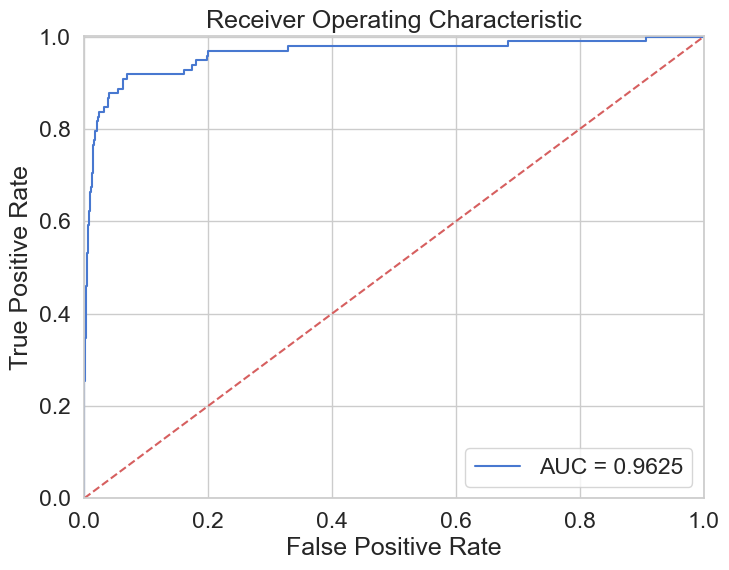

In [114]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

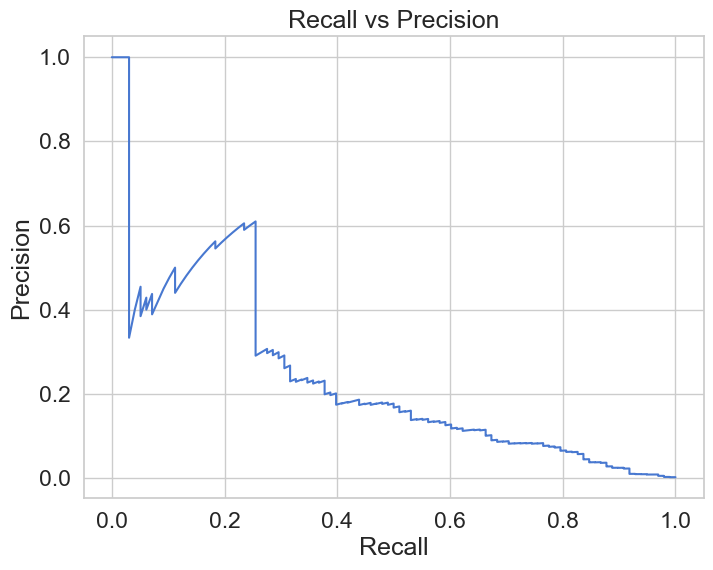

In [115]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)

plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

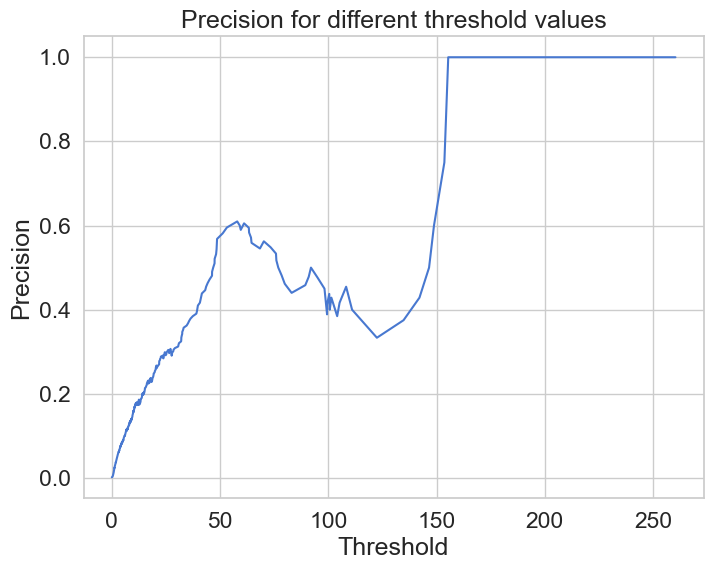

In [116]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

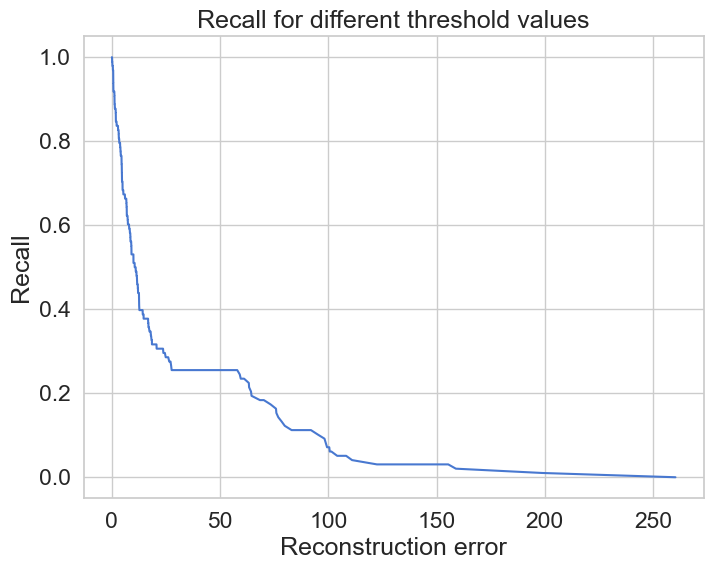

In [117]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [118]:
threshold = 2.9

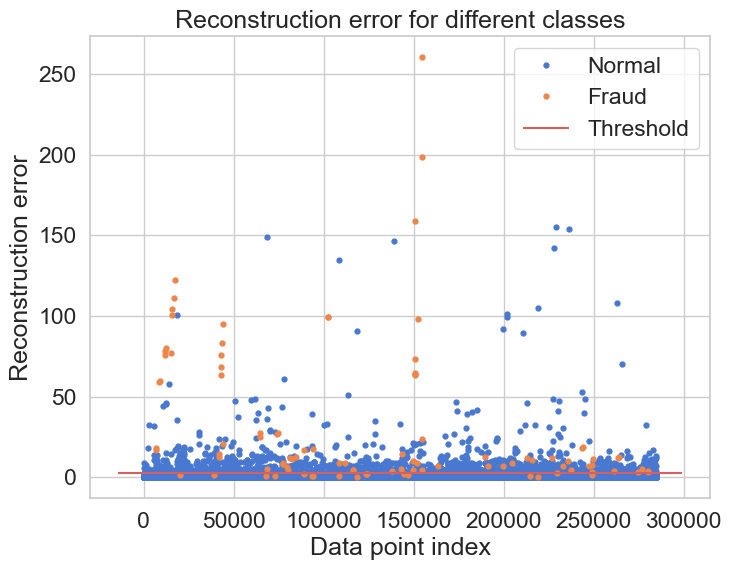

In [119]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

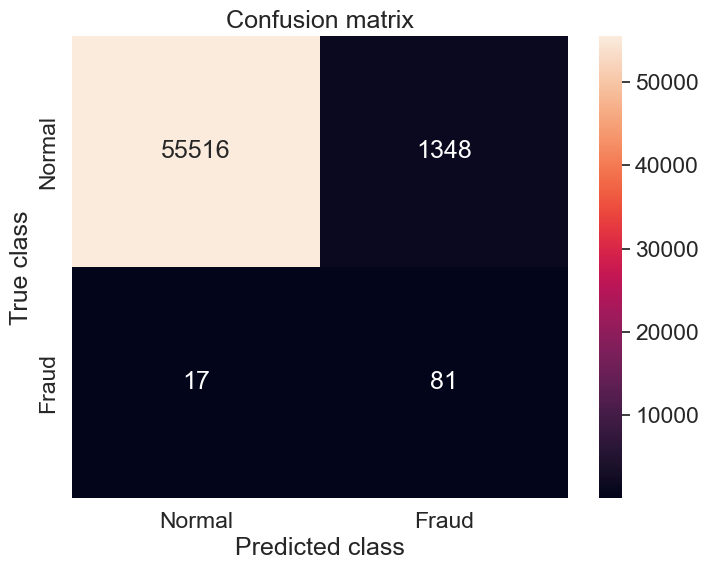

In [120]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()